In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

Off the bat changing size of photos to 64 by 64, this could cause issues later down the road due to image sizes not being square (might modify later)

In [2]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
transform_ds = transforms.Compose([
                                    transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

In [4]:
data_dir = 'C:\\Users\\Lucas\\haileehelp\\GAN_TEST\\A01'
train_ds = torchvision.datasets.ImageFolder(root=data_dir, 
                                            transform = transform_ds)
train_ds

Dataset ImageFolder
    Number of datapoints: 4331
    Root location: C:\Users\Lucas\haileehelp\GAN_TEST\A01
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

4331


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


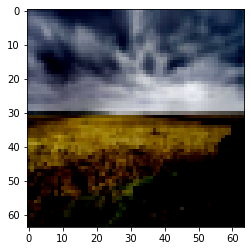

In [6]:
images,_ = train_ds[5]
print(images.size())
plt.imshow(images.permute(1,2,0))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

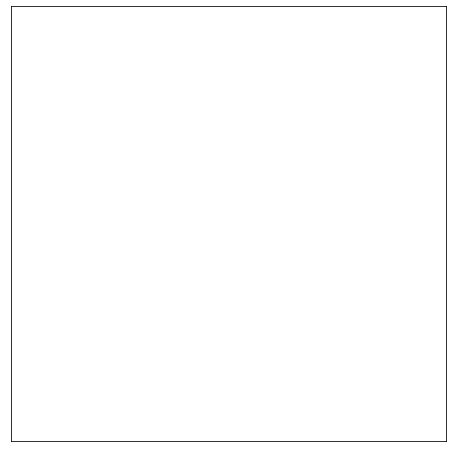

In [15]:
# lets see some more

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

We are moving into the GAN aspect of the code. 
#### Note: using a CNN for discriminator, transposed convolution for generator

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(train_dl, device)

In [10]:
##creation of discriminator --look into deeper later

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [11]:
discriminator = to_device(discriminator, device)

In [12]:
latent_size = 150

In [13]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

torch.Size([128, 3, 64, 64])


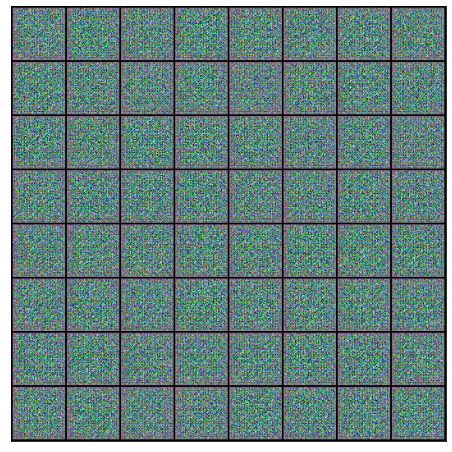

In [16]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [17]:
generator = to_device(generator, device)

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [20]:
from torchvision.utils import save_image

In [21]:
sample_dir = 'GAN_TESTING'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


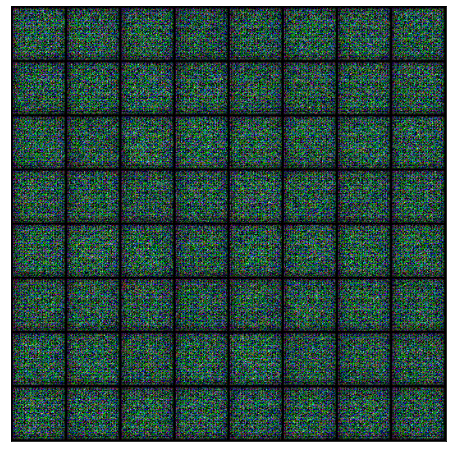

In [24]:
save_samples(0, fixed_latent) # saved inside A01/archive/GAN_TESTING

In [25]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [26]:
def fit(epochs, lr, start_idx=1):
    #torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    #you can use diff learning rates if you want
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [27]:
lr = 0.001
epochs = 150

In [28]:
history = fit(epochs,lr)


Epoch [1/150], loss_g: 3.8378, loss_d: 0.8684, real_score: 0.5031, fake_score: 0.0312
Saving generated-images-0001.png



Epoch [2/150], loss_g: 3.1204, loss_d: 1.3129, real_score: 0.3164, fake_score: 0.0103
Saving generated-images-0002.png



Epoch [3/150], loss_g: 0.6448, loss_d: 1.4065, real_score: 0.3886, fake_score: 0.1249
Saving generated-images-0003.png



Epoch [4/150], loss_g: 2.5493, loss_d: 1.6534, real_score: 0.8077, fake_score: 0.7205
Saving generated-images-0004.png



Epoch [5/150], loss_g: 1.1394, loss_d: 1.3501, real_score: 0.3538, fake_score: 0.1506
Saving generated-images-0005.png



Epoch [6/150], loss_g: 2.2976, loss_d: 1.1364, real_score: 0.7363, fake_score: 0.4917
Saving generated-images-0006.png



Epoch [7/150], loss_g: 0.9164, loss_d: 1.6937, real_score: 0.3104, fake_score: 0.2501
Saving generated-images-0007.png



Epoch [8/150], loss_g: 2.2537, loss_d: 1.7461, real_score: 0.2513, fake_score: 0.0149
Saving generated-images-0008.png



Epoch [9/150], loss_g: 1.6562, loss_d: 0.8220, real_score: 0.6645, fake_score: 0.2939
Saving generated-images-0009.png



Epoch [10/150], loss_g: 2.1178, loss_d: 0.9150, real_score: 0.6318, fake_score: 0.3052
Saving generated-images-0010.png



Epoch [11/150], loss_g: 2.0425, loss_d: 1.2337, real_score: 0.5904, fake_score: 0.4281
Saving generated-images-0011.png



Epoch [12/150], loss_g: 0.9584, loss_d: 1.7351, real_score: 0.2651, fake_score: 0.1745
Saving generated-images-0012.png



Epoch [13/150], loss_g: 1.6599, loss_d: 0.9172, real_score: 0.6385, fake_score: 0.3332
Saving generated-images-0013.png



Epoch [14/150], loss_g: 0.9341, loss_d: 3.0556, real_score: 0.0764, fake_score: 0.0204
Saving generated-images-0014.png



Epoch [15/150], loss_g: 2.1476, loss_d: 1.0184, real_score: 0.7051, fake_score: 0.4325
Saving generated-images-0015.png



Epoch [16/150], loss_g: 3.7992, loss_d: 1.6370, real_score: 0.9011, fake_score: 0.7362
Saving generated-images-0016.png



Epoch [17/150], loss_g: 2.2983, loss_d: 0.9443, real_score: 0.6128, fake_score: 0.2991
Saving generated-images-0017.png



Epoch [18/150], loss_g: 2.0539, loss_d: 1.2815, real_score: 0.5641, fake_score: 0.4540
Saving generated-images-0018.png



Epoch [19/150], loss_g: 3.0285, loss_d: 0.9474, real_score: 0.7007, fake_score: 0.3983
Saving generated-images-0019.png



Epoch [20/150], loss_g: 2.4026, loss_d: 0.9436, real_score: 0.6807, fake_score: 0.3826
Saving generated-images-0020.png



Epoch [21/150], loss_g: 1.7279, loss_d: 1.0203, real_score: 0.6945, fake_score: 0.4235
Saving generated-images-0021.png



Epoch [22/150], loss_g: 5.1262, loss_d: 1.7089, real_score: 0.9062, fake_score: 0.7740
Saving generated-images-0022.png



Epoch [23/150], loss_g: 2.4916, loss_d: 0.7356, real_score: 0.8517, fake_score: 0.3958
Saving generated-images-0023.png



Epoch [24/150], loss_g: 0.7990, loss_d: 1.6524, real_score: 0.3224, fake_score: 0.1724
Saving generated-images-0024.png



Epoch [25/150], loss_g: 4.4921, loss_d: 0.9315, real_score: 0.7916, fake_score: 0.4690
Saving generated-images-0025.png



Epoch [26/150], loss_g: 2.9006, loss_d: 1.0450, real_score: 0.7807, fake_score: 0.5038
Saving generated-images-0026.png



Epoch [27/150], loss_g: 1.2562, loss_d: 0.9326, real_score: 0.5468, fake_score: 0.2033
Saving generated-images-0027.png



Epoch [28/150], loss_g: 3.4207, loss_d: 0.6329, real_score: 0.8606, fake_score: 0.3505
Saving generated-images-0028.png



Epoch [29/150], loss_g: 3.8681, loss_d: 1.0844, real_score: 0.7374, fake_score: 0.4647
Saving generated-images-0029.png



Epoch [30/150], loss_g: 3.1920, loss_d: 1.0375, real_score: 0.8840, fake_score: 0.5046
Saving generated-images-0030.png



Epoch [31/150], loss_g: 1.7988, loss_d: 1.2999, real_score: 0.3473, fake_score: 0.0380
Saving generated-images-0031.png



Epoch [32/150], loss_g: 1.8709, loss_d: 0.7226, real_score: 0.6404, fake_score: 0.1847
Saving generated-images-0032.png



Epoch [33/150], loss_g: 1.9393, loss_d: 0.6448, real_score: 0.6845, fake_score: 0.1734
Saving generated-images-0033.png



Epoch [34/150], loss_g: 1.0668, loss_d: 1.4225, real_score: 0.4250, fake_score: 0.3223
Saving generated-images-0034.png



Epoch [35/150], loss_g: 3.1228, loss_d: 0.8382, real_score: 0.7836, fake_score: 0.3777
Saving generated-images-0035.png



Epoch [36/150], loss_g: 1.6754, loss_d: 1.1669, real_score: 0.5672, fake_score: 0.3158
Saving generated-images-0036.png



Epoch [37/150], loss_g: 2.8898, loss_d: 0.8201, real_score: 0.7237, fake_score: 0.3403
Saving generated-images-0037.png



Epoch [38/150], loss_g: 2.3648, loss_d: 0.7760, real_score: 0.7895, fake_score: 0.3743
Saving generated-images-0038.png



Epoch [39/150], loss_g: 3.7586, loss_d: 0.7635, real_score: 0.8041, fake_score: 0.3750
Saving generated-images-0039.png



Epoch [40/150], loss_g: 1.9540, loss_d: 0.7355, real_score: 0.8374, fake_score: 0.3749
Saving generated-images-0040.png



Epoch [41/150], loss_g: 3.5675, loss_d: 0.6620, real_score: 0.7294, fake_score: 0.2470
Saving generated-images-0041.png



Epoch [42/150], loss_g: 6.2594, loss_d: 0.9763, real_score: 0.8420, fake_score: 0.4849
Saving generated-images-0042.png



Epoch [43/150], loss_g: 1.0519, loss_d: 1.3510, real_score: 0.3606, fake_score: 0.1092
Saving generated-images-0043.png



Epoch [44/150], loss_g: 3.4312, loss_d: 0.5302, real_score: 0.7943, fake_score: 0.2245
Saving generated-images-0044.png



Epoch [45/150], loss_g: 2.5910, loss_d: 0.7478, real_score: 0.6167, fake_score: 0.1627
Saving generated-images-0045.png



Epoch [46/150], loss_g: 3.3514, loss_d: 0.8036, real_score: 0.7439, fake_score: 0.3108
Saving generated-images-0046.png



Epoch [47/150], loss_g: 3.6776, loss_d: 0.9937, real_score: 0.9217, fake_score: 0.5365
Saving generated-images-0047.png



Epoch [48/150], loss_g: 3.9476, loss_d: 0.4545, real_score: 0.8181, fake_score: 0.1884
Saving generated-images-0048.png



Epoch [49/150], loss_g: 2.9792, loss_d: 0.6706, real_score: 0.6832, fake_score: 0.1974
Saving generated-images-0049.png



Epoch [50/150], loss_g: 3.4127, loss_d: 0.5750, real_score: 0.6350, fake_score: 0.0494
Saving generated-images-0050.png



Epoch [51/150], loss_g: 3.4687, loss_d: 0.6228, real_score: 0.7582, fake_score: 0.2478
Saving generated-images-0051.png



Epoch [52/150], loss_g: 4.5322, loss_d: 0.9334, real_score: 0.8258, fake_score: 0.4387
Saving generated-images-0052.png



Epoch [53/150], loss_g: 1.1237, loss_d: 1.0354, real_score: 0.4709, fake_score: 0.0719
Saving generated-images-0053.png



Epoch [54/150], loss_g: 3.5912, loss_d: 0.6819, real_score: 0.8307, fake_score: 0.3399
Saving generated-images-0054.png



Epoch [55/150], loss_g: 4.8094, loss_d: 1.1494, real_score: 0.9011, fake_score: 0.5765
Saving generated-images-0055.png



Epoch [56/150], loss_g: 1.6398, loss_d: 0.7434, real_score: 0.5513, fake_score: 0.0440
Saving generated-images-0056.png



Epoch [57/150], loss_g: 2.2167, loss_d: 0.6495, real_score: 0.6419, fake_score: 0.0898
Saving generated-images-0057.png



Epoch [58/150], loss_g: 3.4487, loss_d: 0.7137, real_score: 0.8778, fake_score: 0.3516
Saving generated-images-0058.png



Epoch [59/150], loss_g: 1.8422, loss_d: 0.8212, real_score: 0.5596, fake_score: 0.0587
Saving generated-images-0059.png



Epoch [60/150], loss_g: 1.4432, loss_d: 0.8069, real_score: 0.6158, fake_score: 0.1791
Saving generated-images-0060.png



Epoch [61/150], loss_g: 2.5776, loss_d: 0.6086, real_score: 0.7169, fake_score: 0.1852
Saving generated-images-0061.png



Epoch [62/150], loss_g: 2.5878, loss_d: 0.7444, real_score: 0.7449, fake_score: 0.2751
Saving generated-images-0062.png



Epoch [63/150], loss_g: 4.9797, loss_d: 0.9214, real_score: 0.9225, fake_score: 0.4952
Saving generated-images-0063.png



Epoch [64/150], loss_g: 2.9185, loss_d: 0.5959, real_score: 0.7634, fake_score: 0.2299
Saving generated-images-0064.png



Epoch [65/150], loss_g: 2.7039, loss_d: 0.3722, real_score: 0.8312, fake_score: 0.1447
Saving generated-images-0065.png



Epoch [66/150], loss_g: 2.6023, loss_d: 0.5116, real_score: 0.8667, fake_score: 0.2606
Saving generated-images-0066.png



Epoch [67/150], loss_g: 2.2932, loss_d: 0.5952, real_score: 0.8341, fake_score: 0.2840
Saving generated-images-0067.png



Epoch [68/150], loss_g: 1.8973, loss_d: 0.6799, real_score: 0.6088, fake_score: 0.0646
Saving generated-images-0068.png



Epoch [69/150], loss_g: 3.4382, loss_d: 0.8359, real_score: 0.7044, fake_score: 0.3215
Saving generated-images-0069.png



Epoch [70/150], loss_g: 2.8388, loss_d: 0.5879, real_score: 0.7195, fake_score: 0.1534
Saving generated-images-0070.png



Epoch [71/150], loss_g: 2.6461, loss_d: 0.7844, real_score: 0.6695, fake_score: 0.2308
Saving generated-images-0071.png



Epoch [72/150], loss_g: 2.1198, loss_d: 0.7902, real_score: 0.5623, fake_score: 0.0542
Saving generated-images-0072.png



Epoch [73/150], loss_g: 7.8337, loss_d: 1.7073, real_score: 0.9734, fake_score: 0.6965
Saving generated-images-0073.png



Epoch [74/150], loss_g: 1.8566, loss_d: 0.4162, real_score: 0.7780, fake_score: 0.1186
Saving generated-images-0074.png



Epoch [75/150], loss_g: 2.2373, loss_d: 0.6636, real_score: 0.6776, fake_score: 0.1613
Saving generated-images-0075.png



Epoch [76/150], loss_g: 3.7380, loss_d: 0.4849, real_score: 0.7543, fake_score: 0.1271
Saving generated-images-0076.png



Epoch [77/150], loss_g: 2.4520, loss_d: 0.6166, real_score: 0.6443, fake_score: 0.0511
Saving generated-images-0077.png



Epoch [78/150], loss_g: 2.5073, loss_d: 0.4570, real_score: 0.7951, fake_score: 0.1290
Saving generated-images-0078.png



Epoch [79/150], loss_g: 2.8434, loss_d: 0.5845, real_score: 0.7289, fake_score: 0.1664
Saving generated-images-0079.png



Epoch [80/150], loss_g: 3.1298, loss_d: 0.4285, real_score: 0.7645, fake_score: 0.0948
Saving generated-images-0080.png



Epoch [81/150], loss_g: 4.0673, loss_d: 0.4077, real_score: 0.9199, fake_score: 0.2384
Saving generated-images-0081.png



Epoch [82/150], loss_g: 2.3931, loss_d: 0.7000, real_score: 0.6596, fake_score: 0.1080
Saving generated-images-0082.png



Epoch [83/150], loss_g: 5.4243, loss_d: 0.4210, real_score: 0.8843, fake_score: 0.1965
Saving generated-images-0083.png



Epoch [84/150], loss_g: 6.0627, loss_d: 1.5145, real_score: 0.9603, fake_score: 0.6588
Saving generated-images-0084.png



Epoch [85/150], loss_g: 4.2125, loss_d: 0.5614, real_score: 0.8976, fake_score: 0.2948
Saving generated-images-0085.png



Epoch [86/150], loss_g: 1.6620, loss_d: 0.5587, real_score: 0.6924, fake_score: 0.0869
Saving generated-images-0086.png



Epoch [87/150], loss_g: 3.2318, loss_d: 0.2633, real_score: 0.9261, fake_score: 0.1454
Saving generated-images-0087.png



Epoch [88/150], loss_g: 3.7050, loss_d: 0.4831, real_score: 0.8309, fake_score: 0.1778
Saving generated-images-0088.png



Epoch [89/150], loss_g: 7.4288, loss_d: 1.2581, real_score: 0.9911, fake_score: 0.5894
Saving generated-images-0089.png



Epoch [90/150], loss_g: 2.9791, loss_d: 0.3964, real_score: 0.8321, fake_score: 0.1499
Saving generated-images-0090.png



Epoch [91/150], loss_g: 2.4339, loss_d: 0.2805, real_score: 0.7997, fake_score: 0.0281
Saving generated-images-0091.png



Epoch [92/150], loss_g: 2.1945, loss_d: 0.4313, real_score: 0.7205, fake_score: 0.0321
Saving generated-images-0092.png



Epoch [93/150], loss_g: 2.8028, loss_d: 0.6882, real_score: 0.6681, fake_score: 0.1157
Saving generated-images-0093.png



Epoch [94/150], loss_g: 3.5056, loss_d: 0.4801, real_score: 0.7903, fake_score: 0.1509
Saving generated-images-0094.png



Epoch [95/150], loss_g: 3.7821, loss_d: 0.4819, real_score: 0.7970, fake_score: 0.1655
Saving generated-images-0095.png



Epoch [96/150], loss_g: 3.6434, loss_d: 0.3475, real_score: 0.7933, fake_score: 0.0488
Saving generated-images-0096.png



Epoch [97/150], loss_g: 5.5849, loss_d: 0.3910, real_score: 0.9625, fake_score: 0.2473
Saving generated-images-0097.png



Epoch [98/150], loss_g: 3.2008, loss_d: 0.2939, real_score: 0.8089, fake_score: 0.0396
Saving generated-images-0098.png



Epoch [99/150], loss_g: 6.2364, loss_d: 0.4461, real_score: 0.9872, fake_score: 0.2800
Saving generated-images-0099.png



Epoch [100/150], loss_g: 3.9273, loss_d: 0.9495, real_score: 0.7832, fake_score: 0.3384
Saving generated-images-0100.png



Epoch [101/150], loss_g: 3.5866, loss_d: 0.6698, real_score: 0.6907, fake_score: 0.0846
Saving generated-images-0101.png



Epoch [102/150], loss_g: 2.5969, loss_d: 0.4356, real_score: 0.7395, fake_score: 0.0789
Saving generated-images-0102.png



Epoch [103/150], loss_g: 4.1587, loss_d: 0.1886, real_score: 0.8809, fake_score: 0.0472
Saving generated-images-0103.png



Epoch [104/150], loss_g: 5.0589, loss_d: 0.2295, real_score: 0.9405, fake_score: 0.1229
Saving generated-images-0104.png



Epoch [105/150], loss_g: 3.2663, loss_d: 0.2825, real_score: 0.8711, fake_score: 0.0901
Saving generated-images-0105.png



Epoch [106/150], loss_g: 8.9589, loss_d: 2.1482, real_score: 0.9917, fake_score: 0.7098
Saving generated-images-0106.png



Epoch [107/150], loss_g: 3.9066, loss_d: 0.3306, real_score: 0.9059, fake_score: 0.1585
Saving generated-images-0107.png



Epoch [108/150], loss_g: 3.6186, loss_d: 0.2587, real_score: 0.8502, fake_score: 0.0568
Saving generated-images-0108.png



Epoch [109/150], loss_g: 5.1975, loss_d: 0.2324, real_score: 0.8723, fake_score: 0.0657
Saving generated-images-0109.png



Epoch [110/150], loss_g: 3.4157, loss_d: 0.2340, real_score: 0.8537, fake_score: 0.0501
Saving generated-images-0110.png



Epoch [111/150], loss_g: 4.0544, loss_d: 0.2233, real_score: 0.8950, fake_score: 0.0855
Saving generated-images-0111.png



Epoch [112/150], loss_g: 2.7120, loss_d: 0.2652, real_score: 0.8369, fake_score: 0.0459
Saving generated-images-0112.png



Epoch [113/150], loss_g: 4.6957, loss_d: 0.6044, real_score: 0.8737, fake_score: 0.2699
Saving generated-images-0113.png



Epoch [114/150], loss_g: 3.6585, loss_d: 0.2644, real_score: 0.8629, fake_score: 0.0712
Saving generated-images-0114.png



Epoch [115/150], loss_g: 2.8961, loss_d: 0.3467, real_score: 0.7932, fake_score: 0.0581
Saving generated-images-0115.png



Epoch [116/150], loss_g: 5.7468, loss_d: 0.2172, real_score: 0.9416, fake_score: 0.1174
Saving generated-images-0116.png



Epoch [117/150], loss_g: 6.5756, loss_d: 0.2969, real_score: 0.9727, fake_score: 0.1912
Saving generated-images-0117.png



Epoch [118/150], loss_g: 5.7538, loss_d: 0.1012, real_score: 0.9507, fake_score: 0.0419
Saving generated-images-0118.png



Epoch [119/150], loss_g: 4.6549, loss_d: 0.1501, real_score: 0.9246, fake_score: 0.0482
Saving generated-images-0119.png



Epoch [120/150], loss_g: 3.2792, loss_d: 1.0910, real_score: 0.6332, fake_score: 0.1719
Saving generated-images-0120.png



Epoch [121/150], loss_g: 3.8787, loss_d: 0.3496, real_score: 0.8345, fake_score: 0.1011
Saving generated-images-0121.png



Epoch [122/150], loss_g: 5.4989, loss_d: 0.7012, real_score: 0.9896, fake_score: 0.3714
Saving generated-images-0122.png



Epoch [123/150], loss_g: 3.4982, loss_d: 0.2196, real_score: 0.8908, fake_score: 0.0675
Saving generated-images-0123.png



Epoch [124/150], loss_g: 4.3992, loss_d: 0.1690, real_score: 0.9249, fake_score: 0.0719
Saving generated-images-0124.png



Epoch [125/150], loss_g: 4.7628, loss_d: 0.1629, real_score: 0.9090, fake_score: 0.0530
Saving generated-images-0125.png



Epoch [126/150], loss_g: 5.5571, loss_d: 0.1535, real_score: 0.9608, fake_score: 0.0882
Saving generated-images-0126.png



Epoch [127/150], loss_g: 5.7218, loss_d: 0.1240, real_score: 0.9803, fake_score: 0.0885
Saving generated-images-0127.png



Epoch [128/150], loss_g: 5.1560, loss_d: 0.0966, real_score: 0.9629, fake_score: 0.0492
Saving generated-images-0128.png



Epoch [129/150], loss_g: 5.1232, loss_d: 0.1334, real_score: 0.9337, fake_score: 0.0468
Saving generated-images-0129.png



Epoch [130/150], loss_g: 4.6585, loss_d: 0.2211, real_score: 0.8746, fake_score: 0.0380
Saving generated-images-0130.png



Epoch [131/150], loss_g: 5.0995, loss_d: 0.1629, real_score: 0.9138, fake_score: 0.0551
Saving generated-images-0131.png



Epoch [132/150], loss_g: 4.5643, loss_d: 0.1283, real_score: 0.9505, fake_score: 0.0611
Saving generated-images-0132.png



Epoch [133/150], loss_g: 6.0799, loss_d: 0.1527, real_score: 0.9662, fake_score: 0.0934
Saving generated-images-0133.png



Epoch [134/150], loss_g: 2.9751, loss_d: 1.1657, real_score: 0.5827, fake_score: 0.1542
Saving generated-images-0134.png



Epoch [135/150], loss_g: 3.6721, loss_d: 0.3138, real_score: 0.8850, fake_score: 0.1159
Saving generated-images-0135.png



Epoch [136/150], loss_g: 4.0938, loss_d: 0.3022, real_score: 0.9208, fake_score: 0.1519
Saving generated-images-0136.png



Epoch [137/150], loss_g: 4.9102, loss_d: 0.2056, real_score: 0.9208, fake_score: 0.0894
Saving generated-images-0137.png



Epoch [138/150], loss_g: 4.3408, loss_d: 0.1712, real_score: 0.9265, fake_score: 0.0430
Saving generated-images-0138.png



Epoch [139/150], loss_g: 4.5251, loss_d: 0.1726, real_score: 0.8861, fake_score: 0.0315
Saving generated-images-0139.png



Epoch [140/150], loss_g: 5.1144, loss_d: 0.1453, real_score: 0.9613, fake_score: 0.0843
Saving generated-images-0140.png



Epoch [141/150], loss_g: 4.6178, loss_d: 0.1383, real_score: 0.9319, fake_score: 0.0446
Saving generated-images-0141.png



Epoch [142/150], loss_g: 5.2342, loss_d: 0.1062, real_score: 0.9720, fake_score: 0.0663
Saving generated-images-0142.png



Epoch [143/150], loss_g: 5.5829, loss_d: 0.0823, real_score: 0.9709, fake_score: 0.0452
Saving generated-images-0143.png



Epoch [144/150], loss_g: 5.5441, loss_d: 0.1171, real_score: 0.9681, fake_score: 0.0738
Saving generated-images-0144.png



Epoch [145/150], loss_g: 4.1437, loss_d: 0.1197, real_score: 0.9420, fake_score: 0.0484
Saving generated-images-0145.png



Epoch [146/150], loss_g: 5.5510, loss_d: 0.1117, real_score: 0.9347, fake_score: 0.0342
Saving generated-images-0146.png



Epoch [147/150], loss_g: 1.5681, loss_d: 1.3801, real_score: 0.5183, fake_score: 0.1759
Saving generated-images-0147.png



Epoch [148/150], loss_g: 2.6796, loss_d: 0.6438, real_score: 0.7200, fake_score: 0.0840
Saving generated-images-0148.png



Epoch [149/150], loss_g: 3.5024, loss_d: 0.4685, real_score: 0.7920, fake_score: 0.1134
Saving generated-images-0149.png



Epoch [150/150], loss_g: 3.3459, loss_d: 0.2574, real_score: 0.8569, fake_score: 0.0622
Saving generated-images-0150.png
